### [Boosted Trees](https://www.tensorflow.org/beta/tutorials/estimators/boosted_trees)

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

import tensorflow as tf

In [2]:
tf.random.set_seed(123)

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

#### Load the dataset

In [3]:
X_train = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
X_test = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = X_train.pop('survived')
y_test = X_test.pop('survived')

In [4]:
X_train.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [5]:
X_train.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [6]:
X_train.shape[0], X_test.shape[0]

(627, 264)

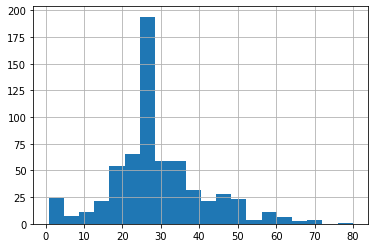

In [7]:
X_train.age.hist(bins=20);

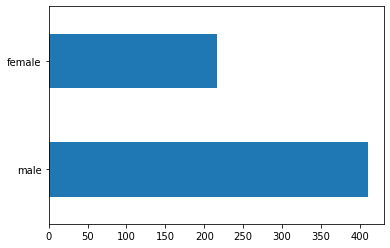

In [8]:
X_train.sex.value_counts().plot(kind='barh');

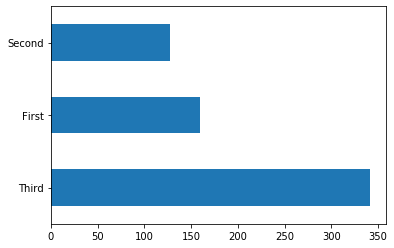

In [9]:
X_train['class'].value_counts().plot(kind='barh');

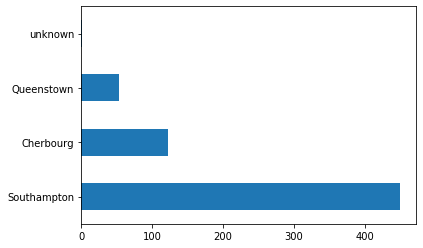

In [10]:
X_train.embark_town.value_counts().plot(kind='barh');

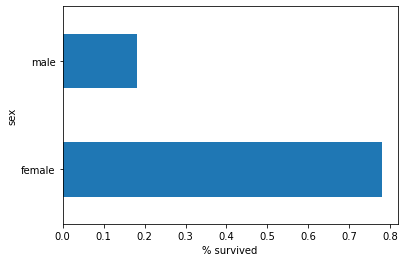

In [11]:
pd.concat([X_train, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survived');

#### Feature columns and input functions

In [12]:
fc = tf.feature_column
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

In [13]:
def one_hot_cat_columns(feature_name, vocab):
    return fc.indicator_column(fc.categorical_column_with_vocabulary_list(feature_name, vocab))

In [14]:
feature_columns = []

In [15]:
for feature_name in CATEGORICAL_COLUMNS:
    vocab = X_train[feature_name].unique()
    feature_columns.append(one_hot_cat_columns(feature_name, vocab))

In [16]:
for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(fc.numeric_column(feature_name, dtype=tf.float32))

An example!

In [17]:
example = dict(X_train.head(1))
class_fc = fc.indicator_column(fc.categorical_column_with_vocabulary_list('class', ('First', 'Second', 'Third')))

In [18]:
print('Feature value: {}'.format(example['class'].iloc[0]))
print('One-hot encoded: {}'.format(tf.keras.layers.DenseFeatures([class_fc])(example).numpy()))

Feature value: Third
One-hot encoded: [[0. 0. 1.]]


In [19]:
tf.keras.layers.DenseFeatures(feature_columns)(example).numpy()

array([[22.  ,  1.  ,  0.  ,  1.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,
         7.25,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ]], dtype=float32)

#### Input function

In [20]:
NUM_EXAMPLES = len(y_train)

In [21]:
def make_input_fn(X, y, epochs=None, shuffle=True):
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
        if shuffle:
            dataset = dataset.shuffle(NUM_EXAMPLES)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(NUM_EXAMPLES)
        return dataset
    return input_fn

In [22]:
train_input_fn = make_input_fn(X_train, y_train)
test_input_fn = make_input_fn(X_test, y_test, epochs=1, shuffle=False)

#### Training and evaluation

In [23]:
clf = tf.estimator.LinearClassifier(feature_columns)

In [24]:
clf.train(train_input_fn, max_steps=100)

In [25]:
result = clf.evaluate(test_input_fn)

In [26]:
print(pd.Series(result))

accuracy                  0.765152
accuracy_baseline         0.625000
auc                       0.832844
auc_precision_recall      0.789631
average_loss              0.478908
label/mean                0.375000
loss                      0.478908
precision                 0.703297
prediction/mean           0.350790
recall                    0.646465
global_step             100.000000
dtype: float64


#### Boosted Trees Classifier

In [27]:
clf = tf.estimator.BoostedTreesClassifier(feature_columns, n_batches_per_layer=1)

In [28]:
clf.train(train_input_fn, max_steps=100)

In [29]:
result = clf.evaluate(test_input_fn)

In [30]:
print(pd.Series(result))

accuracy                  0.825758
accuracy_baseline         0.625000
auc                       0.872360
auc_precision_recall      0.857325
average_loss              0.411853
label/mean                0.375000
loss                      0.411853
precision                 0.784946
prediction/mean           0.382282
recall                    0.737374
global_step             100.000000
dtype: float64


#### Make predictions

In [31]:
preds = list(clf.predict(test_input_fn))

In [32]:
probs = pd.Series([pred['probabilities'][1] for pred in preds])

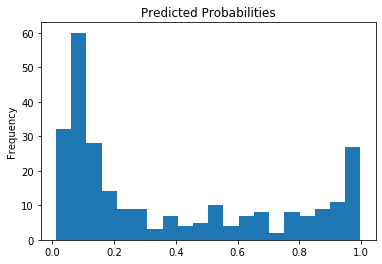

In [33]:
probs.plot(kind='hist', bins=20, title='Predicted Probabilities');

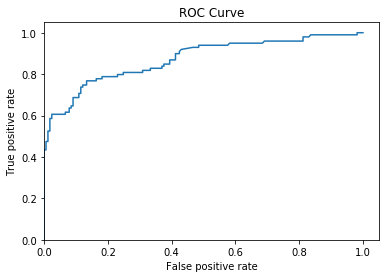

In [34]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, probs)
plt.plot(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xlim(0,)
plt.ylim(0,)
plt.show()